In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from astropy.constants import m_p, M_sun
import astropy.units as u
import matplotlib as mpl
import seaborn as sns
import astropy.units as u
from matplotlib.collections import LineCollection
from plotting_setup import *

sys.path.append('../pipeline_scripts/')
from pipeline_main_nosink import pipeline_nosink
from pipeline_2D_nosink import to_osyris_ivs
from pipeline_main import sink_positions, serialize_directory, sinks, true_sinks, pipeline
from pipeline_streamers import infall_sphere, flow_fraction

core_data = {}
initial_sn = [158, 222, 176, 212, 235, 341, 401, 403, 445]

first_sink_snap = [159, 223, 177, 213, 236, 342, 402, 404, 446]

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:18<00:00, 222.10it/s]


Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:19<00:00, 212.00it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:01<00:00, 2378.62it/s]


Disk size: 63.0 au


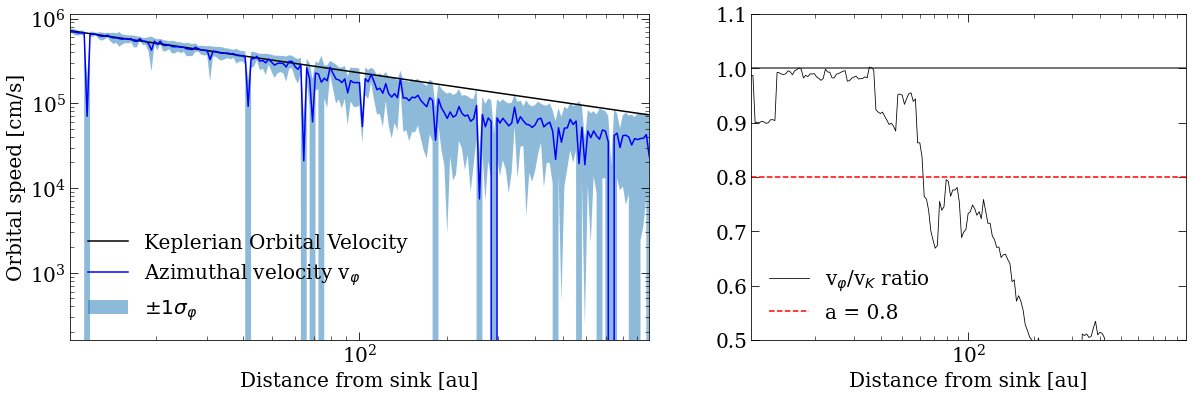

In [2]:
first_snap = 223
last_snap = 512

data_name = 'sink13fmr05'
datai = pipeline(snap = first_snap, run = data_name, sink_id=13)
data = pipeline(snap = last_snap, run = data_name, sink_id=13)

data.recalc_L(verbose = 1); 
data.calc_disksize()

In [66]:
snapshots = np.array([223, 273])#, 373])

In [73]:
# Takes about ~2 min 20s

hammer_data = {}
snap_time = np.zeros_like(snapshots)
for i, sh in tqdm.tqdm(enumerate(snapshots)):
    print(i)
    while True:
        try: 
            data_loop = pipeline(snap = sh, run = data_name, sink_id=13, loading_bar = False, verbose = 0)
            break
        except:
            sh += 1
            print('Going to next snapshot')
    data_loop.recalc_L(); data_loop.calc_trans_xyz(verbose = 0)
    hammer_data[sh] = data_loop.infall_sphere(shell_r=50, get_data=True, plot = False, verbose = 0)
    snap_time[i] = data_loop.time - datai.time

0it [00:00, ?it/s]

0
Converged mean angular momentum vector after 1 iteration(s)


1it [00:11, 11.36s/it]

1
Converged mean angular momentum vector after 0 iteration(s)


2it [00:22, 11.28s/it]


In [74]:
flow_fraction_data = {key: {} for key in hammer_data.keys()}
for sh in hammer_data.keys():
    infall_new, outflow_new, total_infall, cell_areas = data.flow_fraction(hammer_data[sh], verbose=0)
    flow_fraction_data[sh]['infall'] = infall_new
    flow_fraction_data[sh]['outflow'] = outflow_new
    flow_fraction_data[sh]['total_flux'] = total_infall
    flow_fraction_data[sh]['cell_areas'] = cell_areas

In [75]:
flow_fraction_data.keys()

dict_keys([223, 273])

In [76]:
snap_time

array([   0, 9997])

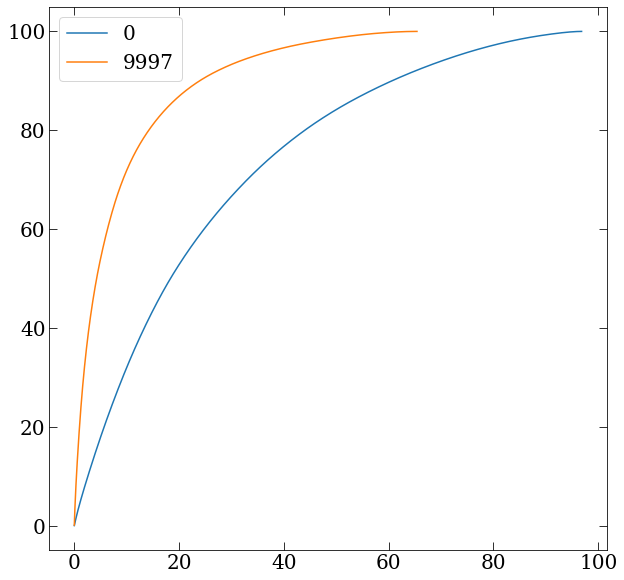

In [77]:
fig, axs = plt.subplots(figsize = (10,10))
for i, sh in enumerate(flow_fraction_data.keys()):
    infall_new = flow_fraction_data[sh]['infall']
    outflow_new = flow_fraction_data[sh]['outflow']
    total_infall = flow_fraction_data[sh]['total_flux']
    cell_areas = flow_fraction_data[sh]['cell_areas']

    x = np.cumsum(infall_new[:,1]) / np.sum(cell_areas) * 100
    y = np.cumsum(infall_new[:,0]) / np.sum(infall_new[:,0]) * 100


    plt.plot(x, y, label = snap_time[i])
plt.legend()

For 0 kyr: 50 % of the accretion happens at 18.4% of the surface area
For 0 kyr: 95 % of the accretion happens at 72.8% of the surface area
For 10 kyr: 50 % of the accretion happens at 4.3% of the surface area
For 10 kyr: 95 % of the accretion happens at 34.3% of the surface area


No handles with labels found to put in legend.


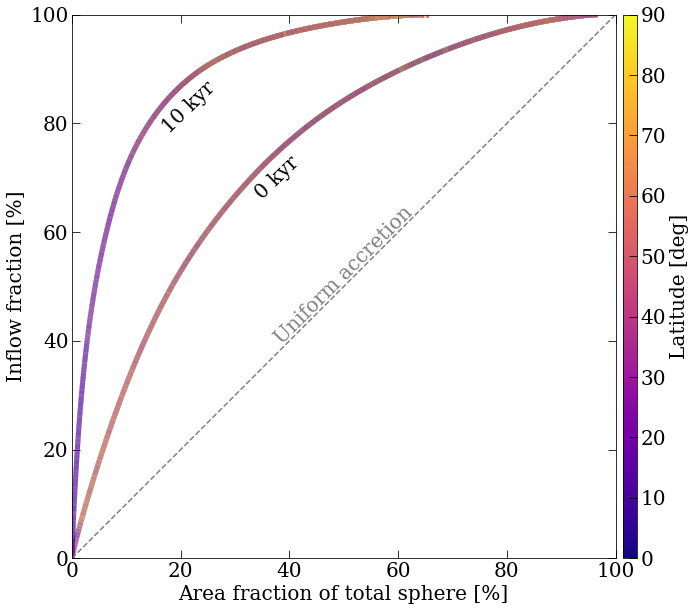

In [109]:

fig, axs = plt.subplots(figsize = (10,10))

label_placement = np.array([[33,70], [16,83], [8,89]])
rotation = [44, 44, 47]

axs.set(ylim = (0, 100), xlim = (0,100))

norm = plt.Normalize(0, 90)

uniform = np.linspace(0,100, 1000)
axs.text(50, 52, 'Uniform accretion', va = 'center', ha = 'center', rotation = 45, color = 'grey')
plt.plot(uniform, uniform, color = 'grey', ls = '--')
axs.set_aspect('equal')
for i, sh in enumerate(flow_fraction_data.keys()):
    infall_new = flow_fraction_data[sh]['infall']
    outflow_new = flow_fraction_data[sh]['outflow']
    total_infall = flow_fraction_data[sh]['total_flux']
    cell_areas = flow_fraction_data[sh]['cell_areas']

    x = np.cumsum(infall_new[:,1]) / np.sum(cell_areas) * 100
    y = np.cumsum(infall_new[:,0]) / np.sum(infall_new[:,0]) * 100
    get_50 = True
    for j in range(len(y)):
        if y[j] > 50 and get_50: 
            print(f'For {snap_time[i]/ 1e3:1.0f} kyr: 50 % of the accretion happens at {x[j]:2.1f}% of the surface area')
            get_50 = False
        if y[j] > 95: 
            print(f'For {snap_time[i]/ 1e3:1.0f} kyr: 95 % of the accretion happens at {x[j]:2.1f}% of the surface area')
            break

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='plasma', norm=norm)

    lc.set_array(np.rad2deg(abs(infall_new[:,-2])))
    lc.set_linewidth(5)
    plt.text(label_placement[i,0], label_placement[i,1], f'{snap_time[i] / 1e3:1.0f} kyr', va='center', rotation = rotation[i])
    line = axs.add_collection(lc)

    axs.set_aspect('equal');
    axs.set(xlabel = 'Area fraction of total sphere [%]', ylabel = 'Inflow fraction [%]')
    #axs.plot(x, y, label = f'T = {snap_time[i] / 1e3:1.1f} kyr', c = colors[i])
    #axs.axvline(x[-1], c = colors[i], ymin = 0 , ymax = 0.05, lw = 4)

    #axs.text(x[-1], 3, f'{snap_time[i] / 1e3:1.0f} kyr', color = colors[i], rotation = 'vertical', ha = 'center')
#axs.set(title = 'Accretion mass fraction at different times')
cbaxes = fig.add_axes([0.9, 0.125, 0.02, 0.755])
cbar = fig.colorbar(line, cax=cbaxes, fraction = 0.04)
cbar.set_label('Latitude [deg]')
plt.legend(frameon = False)
plt.savefig(save_folder + 'mass_fraction_time', facecolor = 'w', bbox_inches='tight', dpi = 500)

In [84]:
shell_data = pipeline(snap = snapshots[1], run = data_name, sink_id=13, loading_bar = False, verbose = 0)
shell_data.recalc_L(), shell_data.calc_trans_xyz()

Converged mean angular momentum vector after 0 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


(None, None)

In [111]:
# Takes ~ 2min 20 s 

shells = [50, 500, 5000, 50000]
hammer_shelldata = {shell: {} for shell in shells}

for i, shell in tqdm.tqdm(enumerate(shells)):
    hammer_shelldata[shell] = shell_data.infall_sphere(shell_r=shell, get_data=True, plot = False, verbose = 0)

4it [00:10,  2.56s/it]


For 50 au: 50 % of the accretion happens at 4.3% of the surface area
For 50 au: 95 % of the accretion happens at 34.3% of the surface area
For 500 au: 50 % of the accretion happens at 7.0% of the surface area
For 500 au: 95 % of the accretion happens at 35.7% of the surface area
For 5000 au: 50 % of the accretion happens at 8.7% of the surface area
For 5000 au: 95 % of the accretion happens at 37.2% of the surface area
For 50000 au: 50 % of the accretion happens at 4.6% of the surface area
For 50000 au: 95 % of the accretion happens at 30.1% of the surface area


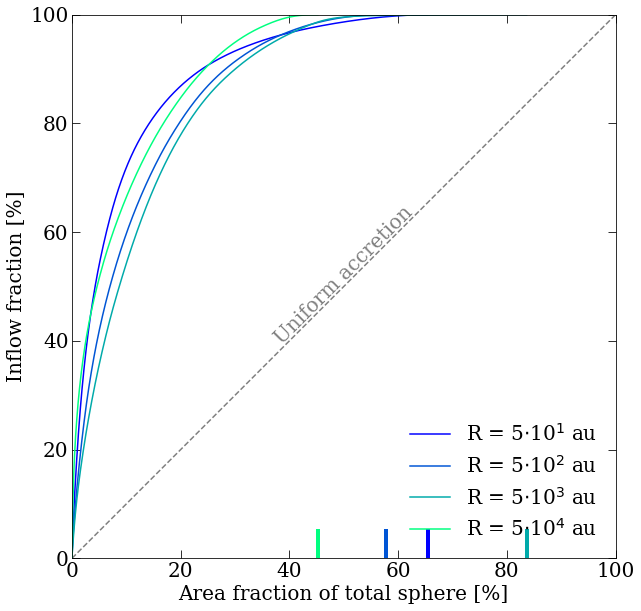

In [115]:
fig, axs = plt.subplots(figsize = (10,10))


uniform = np.linspace(0,100, 1000)
axs.text(50, 52, 'Uniform accretion', va = 'center', ha = 'center', rotation = 45, color = 'grey')
plt.plot(uniform, uniform, color = 'grey', ls = '--')

axs.set(ylim = (0, 100), xlim = (0,100))
colors = plt.cm.winter(np.linspace(0,1, len(shells)))

for i, shell in enumerate(hammer_shelldata.keys()):
    infall_new, outflow_new, total_infall, cell_areas = data.flow_fraction(hammer_shelldata[shell], verbose=0)
    x = np.cumsum(infall_new[:,1]) / np.sum(cell_areas) * 100
    y = np.cumsum(infall_new[:,0]) / np.sum(infall_new[:,0]) * 100

    get_50 = True
    for j in range(len(y)):
        if y[j] > 50 and get_50: 
            print(f'For {shell} au: 50 % of the accretion happens at {x[j]:2.1f}% of the surface area')
            get_50 = False
        if y[j] > 95: 
            print(f'For {shell} au: 95 % of the accretion happens at {x[j]:2.1f}% of the surface area')
            break

    axs.set_aspect('equal');
    axs.set(xlabel = 'Area fraction of total sphere [%]', ylabel = 'Inflow fraction [%]')
    axs.plot(x, y, label = f'R = 5$\cdot$10$^{i +1}$ au', c = colors[i])
    axs.axvline(x[-1], c = colors[i], ymin = 0 , ymax = 0.05, lw = 4)

#axs.set(title = 'Accretion mass fraction at 9 kyr')
    #axs.text(x[-1], 3, f'{snap_time[i] / 1e3:1.0f} kyr', color = colors[i], rotation = 'vertical', ha = 'center')

plt.legend(frameon = False)
plt.savefig(save_folder + 'mass_fraction_shells', facecolor = 'w', bbox_inches='tight', dpi = 500)